In [136]:
# Definindo a versão do TensorFlow para V1.x
%tensorflow_version 1.x

# Importando as bibliotecas gerais:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Importando as bibliotecas Scikit Learn:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.datasets import make_moons

In [137]:
# Definindo a quantidade de amostras:
N = 1000

# Gerando o dataset:
X, y = make_moons(N, noise=0.1, random_state=42)

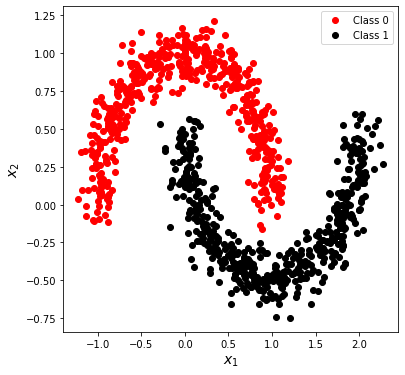

In [138]:
# Definindo os índices
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

# Plotando a figura:
fig = plt.figure(figsize=(6,6))
plt.plot(X[idx0,0], X[idx0,1], 'ro', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'ko', label='Class 1')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.legend()
plt.show()

In [139]:
# Definindo o número de épocas
n_epochs = 1000

# Definindo o passo de aprendizagem:
learning_rate = 0.01

# Definindo o tamanho do conjunto de teste:
test_conj = 0.20

# Defininindo o tamanho do batch:
batch_size = 50
n_batches = int(np.ceil(N / batch_size))

In [140]:
# Concatenando o BIAS junto as features
X_with_bias = np.c_[np.ones((N, 1)), X]

# Remoldando o vetor
y_vector = y.reshape(-1, 1)

# Separando em conjunto de treinamento e teste:
x_train, x_test, y_train, y_test = train_test_split( X_with_bias, y_vector, test_size=test_conj, random_state=42)

In [141]:
# Definição da função hipótese:
x_train_h = np.c_[np.ones((len(y_train), 1)), x_train, x_train**2, x_train**3]
x_test_h = np.c_[np.ones((len(y_test), 1)), x_test, x_test**2, x_test**3]

In [135]:
def fetch_batch(X_train, y_train, batch_size):
    indices = np.random.randint(0, len(X_train), batch_size) 
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch



n = 6; #number of features
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
y_proba = tf.sigmoid(y_pred)
loss = tf.losses.log_loss(y, y_proba)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
loss_summary = tf.summary.scalar('log_loss', loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    
    for epoch in range(start_epoch, n_epochs):
        for indices in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train_h, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_h, y: y_test})
        #file_writer.add_summary(summary_str, epoch)
            
            
            
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
        with open(checkpoint_epoch_path, "wb") as f:
            f.write(b"%d" % (epoch + 1))
    
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_h, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.8710382
Epoch: 100 	Loss: 0.28423518
Epoch: 200 	Loss: 0.22718816
Epoch: 300 	Loss: 0.19350344
Epoch: 400 	Loss: 0.17035101
Epoch: 500 	Loss: 0.15284319
Epoch: 600 	Loss: 0.1391884
Epoch: 700 	Loss: 0.12828867
Epoch: 800 	Loss: 0.11916928
Epoch: 900 	Loss: 0.11152823


In [142]:
# Fazendo predição e calculando a precisão:
y_pred = (y_proba_val >= 0.5)
prec = precision_score(y_test, y_pred)

# Imprimindo o resultado encontrado:
print('A precisão do modelo é de: {:.2f}%'.format(prec * 100))

A precisão do modelo é de: 98.00%


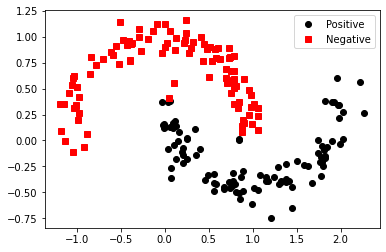

In [143]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'ko', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'rs', label="Negative")
plt.legend()
plt.show()